In [44]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

In [45]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    if len(df['Only identified by site'].value_counts())>0:
        df = df[df[col] != '+'] 
        print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df

In [46]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [47]:
df = pd.read_csv('proteinGroups-all bands.txt',sep='\t')
#print (df.head())
#df['Only identified by site'].value_counts()

df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df.head()


removed  1 Reverse
tot  1  entries removed
---------------
removed  10 Potential contaminant
tot  11  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.7.4700,Tb927.7.4700:mRNA-p1;Tb11.v5.0154.1-p1,Tb927.7.4700:mRNA-p1;Tb11.v5.0154.1-p1,1;1,1;1,1;1,Tb927.7.4700:mRNA-p1 | transcript=Tb927.7.4700...,2,1,1,1,...,11,343,True,348,879;880,1032;1033,1032,NaN,NaN,"WD domain, G-beta repeat, putative"
Tb927.7.5020,Tb927.7.5020:mRNA-p1;Tb927.7.5000:mRNA-p1;Tb11...,Tb927.7.5020:mRNA-p1;Tb927.7.5000:mRNA-p1;Tb11...,1;1;1;1,1;1;1;1,1;1;1;1,Tb927.7.5020:mRNA-p1 | transcript=Tb927.7.5020...,4,1,1,1,...,12,225,True,229,561,660,660,NaN,NaN,"60S ribosomal protein L19, putative"
Tb927.10.6060,Tb927.10.6060:mRNA-p1;Tb11.v5.0199.1-p1,Tb927.10.6060:mRNA-p1;Tb11.v5.0199.1-p1,1;1,1;1,1;1,Tb927.10.6060:mRNA-p1 | transcript=Tb927.10.60...,2,1,1,1,...,13,7,True,8,18;19,23;24,24,NaN,NaN,universal minicircle sequence binding protein 2
Tb927.5.390,Tb927.5.390:mRNA-p1;Tb927.5.360:mRNA-p1;Tb11.v...,Tb927.5.390:mRNA-p1;Tb927.5.360:mRNA-p1;Tb11.v...,1;1;1;1,1;1;1;1,1;1;1;1,Tb927.5.390:mRNA-p1 | transcript=Tb927.5.390:m...,4,1,1,1,...,14,60,True,61,152,189,189,NaN,NaN,"75 kDa invariant surface glycoprotein, putative"
Tb927.10.8480,Tb927.10.8480:mRNA-p1;Tb927.10.8470:mRNA-p1;Tb...,Tb927.10.8480:mRNA-p1;Tb927.10.8470:mRNA-p1;Tb...,2;2;2;2;2;2;2;2;1;1;1;1;1;1;1;1;1;1,2;2;2;2;2;2;2;2;1;1;1;1;1;1;1;1;1;1,2;2;2;2;2;2;2;2;1;1;1;1;1;1;1;1;1;1,Tb927.10.8480:mRNA-p1 | transcript=Tb927.10.84...,18,2,2,2,...,15,52;87,True;True,53;89,134;197,172;232,172;232,NaN,NaN,"glucose transporter, putative"


In [48]:
df.loc[['Tb927.11.11740', 'Tb927.11.11750']]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.11.11740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.11.11750,Tb927.11.11750.1-p1;Tb927.11.11740:mRNA-p1,Tb927.11.11750.1-p1;Tb927.11.11740:mRNA-p1,3;3,3;3,3;3,Tb927.11.11750.1-p1 | transcript=Tb927.11.1175...,2.0,3.0,3.0,3.0,...,49.0,55;108;191,True;True;True,56;110;193,143;144;270;495;496,180;181;311;588;589,180;311;588,NaN,NaN,"membrane-bound acid phosphatase, putative"


In [49]:
df['Intensity 1']=df['Intensity 1']+df['Intensity 1'][df['Intensity 1']>0].min()
df['Intensity 2']=df['Intensity 2']+df['Intensity 2'][df['Intensity 2']>0].min()

df['iBAQ 1']=df['iBAQ 1']+df['iBAQ 1'][df['iBAQ 1']>0].min()
df['iBAQ 2']=df['iBAQ 2']+df['iBAQ 2'][df['iBAQ 2']>0].min()

df['LFQ intensity 1']=df['LFQ intensity 1']+df['LFQ intensity 1'][df['LFQ intensity 1']>0].min()
df['LFQ intensity 2']=df['LFQ intensity 2']+df['LFQ intensity 2'][df['LFQ intensity 2']>0].min()

In [50]:
df['fc1']= df['Intensity 1']/df['Intensity 2']
df['fc2']= df['iBAQ 1']/df['iBAQ 2']
df['fc3']= df['LFQ intensity 1']/df['LFQ intensity 2']

df['log10_score'] = np.log10(df['Score'])
df['log10_intensity'] = np.log10(df['Intensity'])
df['log10_iBAQ'] = np.log10(df['iBAQ'])

df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(5)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb927.11.11750,"membrane-bound acid phosphatase, putative",14.707300,95.333003,10.366242,1.296116,6.524863,5.294400,3672560
Tb927.11.5520,triosephosphate isomerase,9.484041,76.563510,5.753231,1.080157,6.310545,5.196591,2368260
Tb927.10.13800,"hypothetical protein, conserved",6.609107,32.103629,4.009231,0.779236,6.122675,4.800470,1650360
Tb927.1.2410,"beta tubulin, pseudogene",6.449722,49.023107,3.912545,0.792574,6.109444,4.995499,1610560
Tb927.9.10770,polyadenylate-binding protein 2,5.683520,6.819216,13.359392,1.380338,6.770351,5.307945,5499260


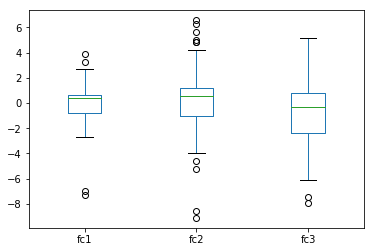

In [51]:
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb927.11.11750,"membrane-bound acid phosphatase, putative",48.815268,48.815268,16.306531,1.296116,6.524863,5.294400,3672560
Tb927.11.5520,triosephosphate isomerase,35.946032,35.946032,9.296844,1.080157,6.310545,5.196591,2368260
Tb927.10.13800,"hypothetical protein, conserved",22.997202,16.306531,6.095089,0.779236,6.122675,4.800470,1650360
Tb927.1.2410,"beta tubulin, pseudogene",16.306531,22.997202,5.845716,0.792574,6.109444,4.995499,1610560
Tb927.9.10770,polyadenylate-binding protein 2,14.886938,4.334134,22.997202,1.380338,6.770351,5.307945,5499260
Tb927.3.4080,"Pyruvate transporter, putative",13.330163,14.886938,2.468810,0.783782,5.937041,4.760950,1189010
Tb927.4.2740,"p25-alpha, putative",9.296844,13.330163,2.288468,1.283912,5.832062,4.752878,1003260
Tb927.11.7380,glycerol-3-phosphate dehydrogenase (FAD-depend...,7.412337,6.556979,2.220119,0.784653,5.808441,4.276967,967300
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",6.556979,6.095089,7.412337,0.848903,5.766993,4.261857,908740


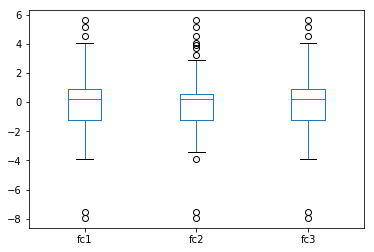

In [52]:
df[['fc1','fc2','fc3']]=quantileNormalize(df[['fc1','fc2','fc3']])
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(10)

In [53]:
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
onesample_results = ttest_ind(df[['fc1','fc2','fc2']].T, 
                              np.ones((3,df.shape[0])))
df['pvalues']=onesample_results.pvalue
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1','pvalues']].sort_values(['fc1', 'log10_intensity'], ascending=False).head(10)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1,pvalues
Gene_id,,,,,,,,,
Tb927.11.11750,"membrane-bound acid phosphatase, putative",48.815268,48.815268,16.306531,1.296116,6.524863,5.294400,3672560,0.000000
Tb927.11.5520,triosephosphate isomerase,35.946032,35.946032,9.296844,1.080157,6.310545,5.196591,2368260,0.000000
Tb927.10.13800,"hypothetical protein, conserved",22.997202,16.306531,6.095089,0.779236,6.122675,4.800470,1650360,0.001414
Tb927.1.2410,"beta tubulin, pseudogene",16.306531,22.997202,5.845716,0.792574,6.109444,4.995499,1610560,0.000895
Tb927.9.10770,polyadenylate-binding protein 2,14.886938,4.334134,22.997202,1.380338,6.770351,5.307945,5499260,0.123262
Tb927.3.4080,"Pyruvate transporter, putative",13.330163,14.886938,2.468810,0.783782,5.937041,4.760950,1189010,0.000013
Tb927.4.2740,"p25-alpha, putative",9.296844,13.330163,2.288468,1.283912,5.832062,4.752878,1003260,0.001221
Tb927.11.7380,glycerol-3-phosphate dehydrogenase (FAD-depend...,7.412337,6.556979,2.220119,0.784653,5.808441,4.276967,967300,0.000034
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",6.556979,6.095089,7.412337,0.848903,5.766993,4.261857,908740,0.000004


In [54]:
df['mean']=df[['fc1','fc2','fc2']].mean(axis=1)

In [55]:
df['log_mean']=np.log2(df['mean'])
df['log_pvalues']=-np.log10(df['pvalues']+0.0001)
df['pvalues']=onesample_results.pvalue
df[['Gene_desc',
     'log_pvalues',
    'log_mean',
   'log10_intensity']].sort_values(['log_mean',
                              'log_pvalues'], ascending=False).head(20)

,Gene_desc,log_pvalues,log_mean,log10_intensity
Gene_id,,,,
Tb927.11.11750,"membrane-bound acid phosphatase, putative",4.000000,5.609261,6.524863
Tb927.11.5520,triosephosphate isomerase,4.000000,5.167761,6.310545
Tb927.1.2410,"beta tubulin, pseudogene",3.002199,4.376219,6.109444
Tb927.10.13800,"hypothetical protein, conserved",2.820000,4.212317,6.122675
Tb927.3.4080,"Pyruvate transporter, putative",3.945050,3.844789,5.937041
Tb927.4.2740,"p25-alpha, putative",2.878985,3.583245,5.832062
Tb927.9.10770,polyadenylate-binding protein 2,0.908819,2.973012,6.770351
Tb927.3.3450,"ADP-ribosylation factor-like protein 3, putative",1.795241,2.934065,5.567356
Tb927.3.1380,"ATP synthase subunit beta, mitochondrial",3.570172,2.801832,5.716988


In [56]:
from adjustText import adjust_text

                log_mean  log10_intensity
Gene_id                                  
Tb927.11.11750  5.609261         6.524863


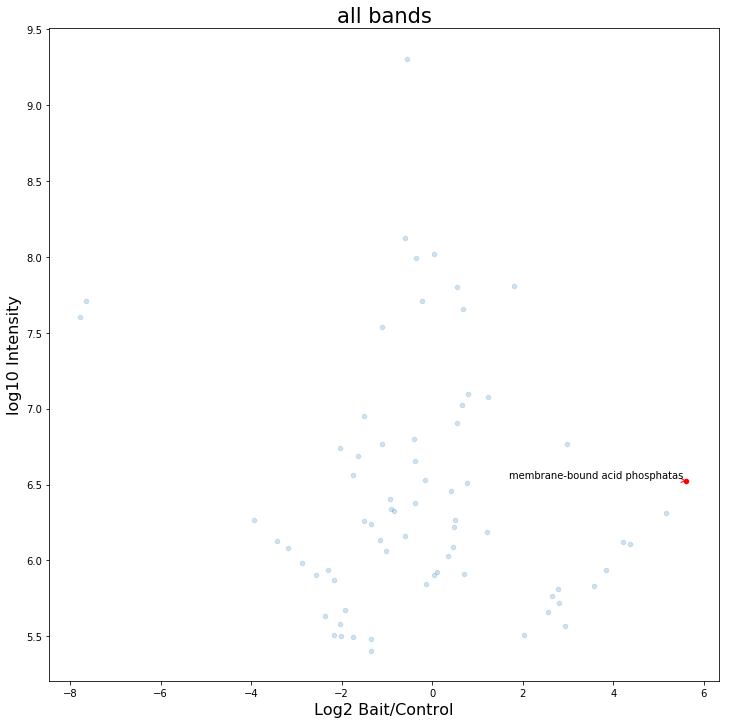

In [58]:
fig,ax=plt.subplots(figsize=(12,12))
df.plot(x='log_mean', y='log10_intensity',kind='scatter', ax=ax,alpha=0.2)


ids = ['Tb927.11.11750']

select = df.loc[ids]#df[(df['log_mean']>5)&(df['log10_intensity']>6.5)]
select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)
print(select[['log_mean','log10_intensity']].head())
texts = [plt.text(select.loc[i]['log_mean'], 
                  select.loc[i]['log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))
plt.xlabel('Log2 Bait/Control',size=16)
plt.ylabel('log10 Intensity',size=16)
plt.title('all bands',size=21)
plt.show()